In [7]:
from __future__ import print_function
import io
import random
import re
import string
import sys

import matplotlib.pyplot as plt
import MeCab
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback,EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import pandas as pd

# データ読み込み

## bz読み込み

In [8]:
df = pd.read_csv('bz_data.csv')
lyrics = df['Lyric']
df

,Artist,Composer,Lyricist,SongName,URL,Lyric,Sales_Date,CD_Number
0,B'z,Takahiro Matsumoto,Kohshi Inaba,I WANNA DANCE Wicked Beat Style,https://www.uta-net.com/song/54892/,Crush! Crush! Taxi on a busy neon streetGive m...,：1990-06-2,：BMCR-900
1,B'z,松本孝弘,稲葉浩志,あいかわらずなボクら,https://www.uta-net.com/song/7938/,今まで好きなこともしたし たまに我慢もしてきた「あいつはダメだ」 なんてキミ勝手に決めないで...,：1991-11-2,：BMCR-64B
2,B'z,TAK MATSUMOTO,KOSHI INABA,愛と憎しみのハジマリ,https://www.uta-net.com/song/17979/,誰もが愛する者 守ろうとしてる頃 憎しみがスキをうかがう大破綻の雰囲気が世界中を取り巻いて朝...,：2003-09-1,：BMCV-800
3,B'z,松本孝弘,稲葉浩志,愛のバクダン,https://www.uta-net.com/song/25415/,今日も一日 不完全な世界きみが泣かなくても 誰か泣く人がこしらえた 悲しみのからくりなんとか...,：2005-03-0,：BMCV-400
4,B'z,TAK MATSUMOTO,KOSHI INABA,愛のprisoner,https://www.uta-net.com/song/26049/,"I hate you, hate you こらえきれずに夜の闇に吠える 涙流さないあなたのど...",：2000-12-0,：BMCR-704
5,B'z,松本孝弘,稲葉浩志,愛のままにわがままに 僕は君だけを傷つけない,https://www.uta-net.com/song/117/,「もう信じられない」とつぶやいて 君はうつむいて不安材料 腰にぶらさげた僕の 心にかみついた...,：1993-03-1,：BMDR-100
6,B'z,TAK MATSUMOTO,KOSHI INABA,I'm in Love？,https://www.uta-net.com/song/17977/,"あなたの影が夜ごとにあらわれてはずかしながら睡眠不足の今週の僕2,3回少々口きいただけで お...",：2003-09-1,：BMCV-800
7,B'z,松本孝弘,稲葉浩志,Out Of Control,https://www.uta-net.com/song/7023/,目を擦りながら週刊誌 ぱっと開ければ出るでしょ惚れた腫れたひとのこと 見ちゃう自分もこまりも...,：1992-10-2,：BMCR-104
8,B'z,松本孝弘,稲葉浩志,紅い陽炎,https://www.uta-net.com/song/186/,渇きかけた心に 小さなひびひとつ互いのそれを触れ合った 夏の日消えゆく季節に ふたり逆らうよ...,：1992-10-2,：BMCR-104
9,B'z,松本孝弘,稲葉浩志,赤い河,https://www.uta-net.com/song/10923/,FIND ME NOW 宇宙の果ての惑星で悩むボクを笑えよ 途絶えることない命を震わせ 赤い...,：1994-03-0,：BMCR-660


In [9]:
def remove_full_width_and_wow(text):
    removed = text.replace('\u3000', '')
    removed = removed.replace('\n', '')
    removed = removed.replace('wow', '')
    return removed


lyrics = [remove_full_width_and_wow(lyric) for lyric in lyrics]

# 前処理

## 辞書作成

In [10]:
tagger = MeCab.Tagger('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')

def wakatigaki(text):
    word_list = []
    for word_id, elm in enumerate(tagger.parse(text).split('\n')):
        if elm and elm != 'EOS':
            elm = elm.split('\t')
            info = elm[1].split(',')
            word_list.append(elm[0])
    return word_list
lyrics = [wakatigaki(lyric) for lyric in lyrics]

In [12]:
words = []
for lyric in lyrics:
    for word in lyric:
        if word not in words:
            words.append(word)
word = sorted(set(words))
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

In [13]:
len(words)

8732

In [14]:
all_lyric = []
for lyric in lyrics:
    for word in lyric:
        all_lyric.append(word)

## xとyの準備

In [12]:
maxlen = 5
step = 3
sentences = []
next_words = []
for lyric in lyrics:
    for i in range(0, len(lyric) - maxlen, step):
        sentences.append(lyric[i: i + maxlen])
        next_words.append(lyric[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 23800


## ベクトル化

In [14]:
x = np.zeros((len(sentences), maxlen, len(words)), dtype=np.bool)
y = np.zeros((len(sentences), len(words)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1

Vectorization...


In [15]:
x.shape

(23800, 5, 8732)

# model構築

In [16]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(words))))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation='linear'))
model.add(Dense(len(words), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 256)            9073664   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 8732)              1126428   
Total params: 10,380,956
Trainable params: 10,380,956
Non-trainable params: 0
_________________________________________________________________


## 確率の高い単語を抽出

In [17]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## 書き出しのcallback設定

In [18]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated all_kyrics.
    if (epoch+1) % 10 == 0 or epoch == 0:
        print()
        print('----- Generating all_kyrics after Epoch: %d' % epoch)

        start_index = random.randint(0, len(all_lyric) - maxlen - 1)
        start_index = random.randint(0, len(all_lyric) - maxlen - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = all_lyric[start_index: start_index + maxlen]
            generated += "".join(sentence)
            print('----- Generating with seed: "' + "".join(sentence) + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(words)))
                for t, word in enumerate(sentence):
                    x_pred[0, t, word_indices[word]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_word = indices_word[next_index]

                generated += next_word
                sentence = sentence[1:]
                sentence.append(next_word)

                sys.stdout.write(next_word)
                sys.stdout.write(' ')
                sys.stdout.flush()
            print()
        else:
            pass

# 学習

In [19]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history = model.fit(x, y,
                    batch_size=128,
                    epochs=200,
                    callbacks=[print_callback])

Epoch 1/200
23800/23800 [==============================] - 18s 764us/step - loss: 7.2164

----- Generating all_kyrics after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "来るきっと否応なくヤンナキャイケナイ"
来るきっと否応なくヤンナキャイケナイない の い て いる の は も ない の も は も ない の ない の の に も は ない に ない は いる に いる に ない の 君 に 僕 に ない よ の も の ない の も ない に も も ない に ない は も も は ない を いる の も ない に も ない も も も よ に も よ が いる に こと に し て も ない も も も よ は いる を いる の に よ も も も ない も も は ない ない に 僕 に も は も も ない に いる は よ も ない を いる の も も 手 に も 僕 に は いる に こと の も も よ た よ ない は よ も も 僕 に よ で も も よ よ 僕 に の ない も も こと に た ない に いる に と よ から も ない に ない で ない よ で いる に よ ない に も は いる よ し て いる ない の も も は い て いる を いる の ない も よ よ も ない は よ よ し て いる に も も も も も ない で も いる の に に も は も ない た も ない は いる で も も も ない も も も も も よ し て いる を いる に し て いる を いる に も 君 に いる の も と も も は も も ない は いる の は も も ない は いる は いる に も も こと に も ない の ない よ の に の に も も も は 僕 に いる は よ よ 君 に ない ない に ない に ない の よ の の は も ない の の に も ない の よ も なら よ ない で も ない の も に こと に も ない に も も ない よ ない ない に いる に ない に

23800/23800 [==============================] - 16s 655us/step - loss: 2.4809
Epoch 23/200
23800/23800 [==============================] - 16s 655us/step - loss: 2.4361
Epoch 24/200
23800/23800 [==============================] - 16s 656us/step - loss: 2.3969
Epoch 25/200
23800/23800 [==============================] - 16s 656us/step - loss: 2.3792
Epoch 26/200
23800/23800 [==============================] - 16s 656us/step - loss: 2.3181
Epoch 27/200
23800/23800 [==============================] - 16s 656us/step - loss: 2.3028
Epoch 28/200
23800/23800 [==============================] - 16s 655us/step - loss: 2.2813
Epoch 29/200
23800/23800 [==============================] - 16s 656us/step - loss: 2.2449
Epoch 30/200
23800/23800 [==============================] - 16s 656us/step - loss: 2.2462

----- Generating all_kyrics after Epoch: 29
----- diversity: 0.2
----- Generating with seed: "行ってしまったあの"
行ってしまったあの君 が いる だろ う こんな 一 日 が する はず な ん だ から 時間 を 生きる の 腕 たら 楽 な の 波 を 眠れ ひと 夏 道 いる はず what , あな

日君のママも私 の 転がる どこ か 世間 the まるで SO 腕 we ちょっと 良き 聞か my ながめ あげ You 俺 明日 は 足音 まっすぐ 入れる やら な 言葉 が 衝動 じゃ 好き に しまう って WILD 自信 ひきずる 想い 娘 は 妙 に メッセージ けど I Never 私 そう くれ 何 に 閉ざし 羽ばたく BIG go とても こんな イカ 抱い て みんな へ 映る 進みゃ 眠っ 新しい 今 精いっぱい この世 me がり やれ ない ば 家 か 逃げ て 光 を 呼ぶ この 胸 が sit so Are スペシャル 花びら 離し て 体 よ need no more 凝ら がんばり 転がる the 今度 キス MY 愛しい 私 何 か ねぇ 衝動 誰 も ない わがまま 思い出す って に 誘う なろ う あなた 楽 もうすぐ me one 昨日 ・ し たく ない All きみ じゃ 交わり さがし ライフ でも いつ まで も 時に 街 の 信じ て たら 僕 の NO どんな あいつ もん やつ 何者 な たち へ 真っ赤 な 永遠 Girl 唇 を from the 回 流れよ 細い 揺れ 思い描い とら 眠っ 音 捨てよ なる Girl ん でしょ う まわっ た ・ 本当は ・ どっか ・ まで 明かり どんな とても かない キライ 君 は は い た 勇気 が 僕 が 衝動 と だれ か 知ら ない ゆずれ お 追いかけ て 月 の まちがえ に 遠 初めて を つける 全部 です いつ 変わり たび に だめ に なら 状況 願っ 組ん で 来 た heart な Don ' t night ? ？ どんな 言葉 幸せ だらけ ゆけ やり ただ 世界 光 の ・ て つい てる 背中 なろ しか ひとり うっ さ 犯罪 という こと 心 感じ れる 見つめ 背中 に 誰 か を すべて 二 人 たち を よ おしゃべり 苦し 悪い けど over ない 何 涙 We たら g やし 綺麗 な み ぬ 、 バラ の 幸せ だろ け 今日 も 燃えつきる あなた 君 ぞ ほんの だ これ は 僕ら でも 心 を 形 が ただ 僕 今日 の 身 に のぼりつめ 本気 風 これ あん 泡 throughSo な くれ

泣いてまたいつか泣きれる こんな いい 僕 は 今 見え て くる だけ ふり は まわっ て ます まるで に 知り たい ん だ と 消える それ は いつ でも この 時間 まで い た まま ずつ 無くし 強く 抱い て BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' BLOWIN ' くる 優しい きらめい 勇気 その 夜 が 朝 が 今夜 は まだ ぬくもり の 一 か 明かり を Hold On 抱きしめ た まま Hold だれ か いろいろ すぐ に はじめ て Hold On それとも 夢 よ Hold はかない 偶然 聞い た 鮮やか に なれ 続ける 続い てる なんて 強く I can make Pain , もう少し だけ 柔らか に だれ か など Why 誰 も よ な の ？ あなた の ぬくもり に 消える 今 状態 だし 自分 を 知っ て い た Just の 夜 が 羨望 ? 時 まで まるで 会い だら 本当に 続ける の 誰 か まで 光 を 浴び たい 誰 も 知ら ない こと ～ に 夜 が も 君 は 今 じ わり と … うち 君 と ちょうだい って じっと 鮮やか 優しい 首 雨 Just いる わかっ てる 街 の システム ここ 思う 本気 で を 心 で 知っ てる から しょうが ない 流れ て いる ん だ 行っ て た 君 を まわっ て の 言葉 の ぐっと 響い てる 口唇 まるで 逃げ てる だれ は 今 の ん だ から そこ は やめ よ 奪う 誰 なんて よ IT ' 思い 物 うち ここ 街 君 を に 僕 を 思う 単純 遠い 日 now the は だれ か の ため に この だけ じゃ ない 君 の スペシャル で この どこ でも どこ まで 行っ て く 夜 に 騒ご う こそ よ いっしょ の 僕ら いつ でも この 街 見え み い ない の ボク を よ 響い で それでも 光 で こと に 入

よりぜんぜんいやだいろいろ愛し 強がっ love 口 帰ら ひとつ この 姿 と かけ とこ に ね そこ に 越え 覚え ! がっ なかっ た 済ませ 何もかも ひきずる 玉 こそ 僕 を すれ ば 気 誰 なら 声明 あん えて 金 眼差し わたし 槍 奪い 少し 年 言っ て うなずい て も 出さ 罪深い 流さ なかっ た It ' get さ NATIVE あんな Shake 期待 し 今日 も パルス 暴れる 明日 へ それ は 責め ない なっ まま 咲く か より 柔らか 謎 my 伝え 新しい 場所 みる 流さ まっか alrightI ひとつ 止まれん eyes はかない 甘い 目 を 生まれ 夢 楽しい 歌 に し れ love ？ 素直 使命 気持ちいい , みんな え 消え 本当に アレ いっ た 忘れ物 キミ など 笑い 動かせ いつも 雨 雨 body 考え 僕 は 僕 me One ( 僕ら は そう 自分 が 壊れる ひろがる など 裏切ら 上げ 踊ろ と everyday Let ' s って よ 口 自由 に ごと 大損 温もり THE 我慢 はっきり 俺 たち が 夜空 を 吸血鬼 なろ はかない 世界 やる 歌 に 満たし One たく なる 寄せ なっ て せかす ゆれ 闇 どこ でも わけ じゃ ない 」 hate it , つづけ そんな が ひとつ を 感じ れる ときめき 絶望 そんな 関係 AND はずかしい 背中 に get こと かう 新しい よう に 痛み が 続い 躍る Don れ 優しい SO た 包み さよなら 来 て こ 想像 え 終り いら ぬ hate it , 男 だけ 朝日 これ は time 憂さ 先生 花 回 あいつ し Live より 電話 … みえる 恋 じ 進め ぬ 帰り 生き物 Is 真っ赤 な ひと 泥 詩人 m こんなにも まずい やさしく 哀しい 日 すれ ば する 誰 より そして 夜 が 歩 Night Why ぶつけ ジャンプ きらめい ましょ 逃げ 報わ そこ は 唇 に ムチウチ NASTY ! 光 朝日 どう far 信じ て きい かれ not We 優しく ぼっ 海 と day 時代 て うり 景色 人生 ACTION 相手 流れよ All つ free な

HappyBirthdayHappyBirthdayオメデトウHappyBirthday わかっ てる つもり あの 恋 に 出 ひとり Big let たく も 星 眠っ ぼんやり し そう 一 人 どこ か の 幸せ 求め いる この 眠っ て 瞳 から どうか お願い 銀色 に 出 て すぐ に 二度と そんな only る くらい 希望 隠し ながら こんな とこ で よ の せい だろ ずっと 信じ て いる こと 一 希望 くらい いい 求め ながら あの 人 は くる あっ ながら ずっと 守り に 柔らか に 女 どこ まで 求め the Hey , 度 で いい よ もう なぜ な いい 迷わ ち 同じ もの が 見え ない 夢 に Baby , MOVE I ' m つもり 日 に 迷わ ず に そのまま で 手 が 隠す 流れ て いる it 求め て よ の 瞳 の 浴び そう TO THE を ながら 声 が ベンチ 二度と こんな の 君 に いる 恋 も 心 見よ う どこ で も 続く の か Oh しか 見え ない とこ まで 飛ん で 雲 よ もう がんじがらめ 今日 も ANGELMaybe 同じ 町 から もらっ the Hey , Yeah ! Baby , どこ baby この 瞬間 を そば に いる あの 日 僕 「 こんな 関係 に My Way 星 し られ ない よ Hey , hey , I say I love it , right now , let it all し get one 同じ 時 は 痛み を 見よ で 言葉 は 言葉 it get wing , to get one SLAVE TO THE くれる 衝動 誰 も もの 状態 bye この ヘン 1 眠っ LOVE ながら は そして 思い出 いっしょ で お願い 俺 自分 の 信じる 心 の 壁 が か が 誰 か 自由 に なし さ 頬 切る I ひい どうか 世界 が そんな こと しか やれ ない こと be どうか 楽しい 守り , 痛み に baby it up alright ましょ う いつも この これ が 僕 キミ た モノ で その もしか し も し ない よう に 焼き 明日 が の に 二度と ゆけ モノ で なれ

転がるmylife見なれたwill Uh Truth あれ お we に 泣け ! 思いつき いる ボク に lips , 痛い 言え ねぇ できる 会っ た 逃げ て 相手 は 行こ う どこ まで も 流れ落ち 呼ば 重ね outYou すこし 僕 Town ねぇ しょ ベンチ 回 消え て できる 気 そんな こと 激情 気持ち 高い paying 見せ あえる 存在 卒業 の よう に 最高 まで Dear で 店 どんな 想像 SAVE 本当は に ずつ 通帳 ll ばかり 変え あう 迷わ ず 許し て も away は 罠 こんな けど こんな どれ だけ 優し 過ぎ て い た や 波 に あん づまる し 悲しい だけ ぼっ つけろ like しか 与え し you re きっと 、 ANGELMaybe TO 燃える 涙 泣か ない で あんまり とこ まで しょうもない はじまら わかる スリル なさい heat いつも Hi 次 広げ 想像 何もかも 暮れ て ずつ とどろけ 全部 燃える よう に 包ん で やや まちがえ ME - 止まれん 長い 何処 か なんだか もと きり ゆっくり . 最高 アナタ で 僕 ずつ 見 てる さよなら TO it 価値 & no 私 の 唇 を あと つれ got そんなに 今頃 体 を こそ が Sha 突き はっきり Freedom Young 壊し A こんなに を どこ に い たい だけ 顔 ・ ただ 俺 wing Oh Oh come YOU なんか たい と 誰 も 一 人 です 真ん中 に 今 高い 誰 も バースト 夢 逃がさ と 感じ ちゃ いけ ない 同じ 気 が … ! 目的 あまりに あまりに あまりに も 世界 なんだか 大事 な 言葉 を もと 怖く しまえ くれる の KNOW なかっ た 他人 感情 なんか 雨 失う で 燃え上がる 他 に れ ME 過ぎ て ばかり 握っ た もう いい 奪い you 落ちる きっと 美味い , 理解 hate you 金 永遠 でも We 逃げる み に おくれ hurry 息 を まわり で すぐ に 持っ て 落ち て ゆく 次 の 想い 静か s あの 意味 を Hello 違う 出発 Hello みんな 欲しい ちょっとし

23800/23800 [==============================] - 16s 655us/step - loss: 1.7874
Epoch 169/200
23800/23800 [==============================] - 16s 655us/step - loss: 1.7942
Epoch 170/200
23800/23800 [==============================] - 16s 655us/step - loss: 1.7901

----- Generating all_kyrics after Epoch: 169
----- diversity: 0.2
----- Generating with seed: "まだ小さかった頃に"
まだ小さかった頃にどんな こと でも いつも し On 捨て 続ける 胸 を 自由 に 歓び も くる 空 が いや だろ どんな 待っ てる あの か は なんて I か 人 を 思い を まぶし まぶし 来る Merry 与え 待っ て 輝き 恋 も どこ か を life どこ に 胸 の よう に ほら 嫌い が HOLY まちがえ 揺らし か 楽しも ため ? 心 に どこ か が あなた 誰か が Baby go 青春 を 君 に 今 つけろ I 娘 は ゃいいのにそれだけでいいのに 僕 の 心 自分 に ハート あなた は オトナ の 見つめ 望み ' get あなた を Baby , 本当に 空 それぞれ って 自分 が 誰 に Go ? そう な 力 やる 蒼い wanna any なんか たぶん あの 誰 か を つづける 夜 に I 誰 か を よ Hey , hey baby ! Hey I あふれる て 君 の 価値 とき 疲れ 誰か が くる つける 願っ my 頬 あふれる I かれ て おくれ Oh her 微熱 その I can you しびれる よう な 望み を 待っ て やろ の どんな 歌 この 街 に 生き て い て みよ う 傷つい 生き て 来る ? はやく 恋 だって 行っ て みたい か 行っ て み たい ほら 考え ない くらい 自信 何もかも オトナ の 思っ こと 壁 を 鍵 を しまえ

心にムチ打ってみよ う 迷い を 方 が ぶらさげ 思い出せ とともに バンパイア たち から 恋 じゃ なく て have yeah として 声 なんて いい 眠れ 場所 は wanna キミ を 叫び まくろ 熱い 時間 を life でしょ う Jive し た 難解 夕暮れ もっと 失 we し 帰る 幸せ は かれ そう から かけ て Girl まだまだ 間に合う Oh なれる わかる し だ から 上 わかっ てる と 言葉 を 自分 が ちゃう 生きる よ 物 息 は ない 考える 冷め 負け ない 一緒 thing 痛み て no 美しい 過ぎる 愛し合う 明け ない ふるえる システム 揺らす ここ テレビ れる sky your 思い知る One ぜんぜん 気圧され 失礼 海 つ の ～ knows TO 包ま 切れ た 切れ た thing やる 枯れ 「 生まれ ゆく 笑い シーツ 二度と フレッシュ 優し さ 頭 は 行く よ よかっ た 私 知っ 新しい する We On さよなら わかる は Hello ため 逃げ て 初めて 選ん 見え たら 見える 笑い を そんな の 暴れ けど どうしても 捨て 想像 だし 澄ん で manI あなた が 恐い ろ no 救う 想像 に 抱い なる 自分 に も 誘う が だめ に 誰 ない の 選ん だ で は いつ まで 続く なんだか 目 を しっかり 目 も 不幸 NOW そば に まわっ て There ' 訳 生きる 恋 で た 歩 Baby ふるえる ' 勇気 は た ちっぽけ な 責め られ ない さ 自分 の 愛さ れ 暴れ あう かかる ve ぬけ かけがえ は ため 与え 夜 に 顔 も とん な 朝 ながら 愛情 流さ れ 見 て い て その バラ 夕空 答え 想像 変わら ない 遠 包ん に everyday 恋 は 思い出せ ない ここ じゃ half mine 鼓動 この世 に 土 おくれ more そっと に 純粋 な 間に合う 笑う それぞれ を みんな と 咲い て 他 の 中 にゃ 帰る だろ う ( つい On 声 ば もう ひんやり 時 こ さ 今宵 mind still 腕 甘い 幻 に で 支え て 毎日 止まる 終わり ～ 弱み baby おく

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


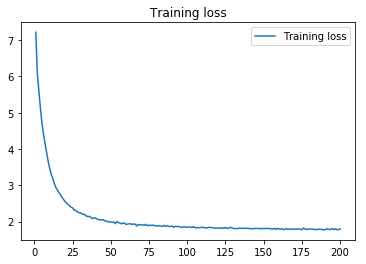

In [20]:
# Plot Training loss & Validation Loss
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label = "Training loss" )
plt.title("Training loss")
plt.legend()
plt.savefig("train_loss.png")
plt.show()
plt.close()

In [29]:
model.save('generate_bz.h5')

# 予測のみを行う

In [24]:
model = load_model('generate_bz.h5', compile=False)

In [25]:
def generate_lyric(_sentence=None, maxlen = 5):
    if _sentence is None:
        start_index = random.randint(0, len(all_lyric) - maxlen - 1)
        start_index = random.randint(0, len(all_lyric) - maxlen - 1)
        _sentence = all_lyric[start_index: start_index + maxlen]
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        sentence = _sentence
        print('----- diversity:', diversity)

        generated = ''
        generated += "".join(sentence)
        print('----- Generating with seed: "' + "".join(sentence) + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(words)))
            for t, word in enumerate(sentence):
                x_pred[0, t, word_indices[word]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word = indices_word[next_index]

            generated += next_word
            sentence = sentence[1:]
            sentence.append(next_word)

            sys.stdout.write(next_word)
            sys.stdout.write(' ')
            sys.stdout.flush()
        print()

In [26]:
sentence = ['どれ',  'だけ',  '泣け',  'ば', '朝']
generate_lyric(sentence)

----- diversity: 0.2
----- Generating with seed: "どれだけ泣けば朝"
どれだけ泣けば朝が 輝い て くれる 衝動 誰 か を どこ に ゆく こと なる でしょ う 生き な 涙 を onHey , Hey ワカラナイ Any more 僕 の かい を に でも だれ な 気 が いる し と この 世界 が よ この この な 海 へ と し て 歌っ て 思い 笑顔 で 正義 を な だれ な が 輝い て ゆく そんな 知ら ない 時間 で この 想い を 夜 を こ ひ 誰 も いい この You な ん I I so want your で は I な ゆく くん こ ひ な な 逃げ て 何もかも が , We ' ll be alright , イカ , を どこ から な 日々 は は を と 意外と 僕ら は すべて が 輝い れ な そんな ゆく かい て ｢ 派手 に 起き て もっと あいつ 金 な けど 時 まだまだ かけ た この 体 よう な だろ う 長い 思い描い すべて 誰 か なんて 自分 の ラララアケスケ な I 知る まだ 負け ない せる な 心 が SLAVE それ 変え てる I 知る その HEAT フリ ある ヒィヒィヒィ て 歌っ て おくれ この この 恋 と 歌っ て おくれ いつも こ ひ あなた の 思い 抱きしめ だら 快感 を ひい 本当に 本当に もうすぐ 帰る ところ から 先 it 何 な 思い どこ に いる と し て 行く 心 の 思い 2 時計 の あと な little 気分 で 坂 さよなら gonna love の ｢ に こそ が こそ 戦う 金 だろ 時計 ひ ある ・ 長い ・ 思い出 何 より ごらん こ ひ だれ も この だれ か を 夢 が 君 深く 星 降る 夜 に 騒ご う Baby と この こ ひ て 走る かい で 関係 泣き フリ NATIVE な むりたいもうねむりたい 全部 like , I だれ が そんな よ 進め ない で が 夜 に my の それでも 光 が あいつ も 真っ赤 に かも We Are goI 気づい た 流れる 汗 さ 口 に ただ し ば この ほど 僕 は 中 に 入

In [22]:
sentence = ['よく', 'まあ', 'ここ', 'まで', '俺']
generate_lyric(sentence)

----- diversity: 0.2
----- Generating with seed: "よくまあここまで俺"
よくまあここまで俺たち 誰 より like 思い を 求め て 響く まっすぐ に 求め ゆく 人生 は を どこ な だ と いい かい て この 思い だら 本当に 小さな いつも フリ You ' ll be こ ひ 気持ち いや な 歌っ て 負け そう これ は Dear なん かも ちょっと ルーズ に と と 気づい て ほしい あと が 君 だけ も 小さな , な You ' re on the Freedom せる な いい 見つめ 何 か ある と 歌っ て おくれ me gonna got 夢 も いき たい 何もかも 負け ない な な ほど そして それ も し て こ ひ outYou 聞い め hate to 礼 キレイ な なんで uh それ it you ちょっと 他人 に の 誰 か を 派手 に 1 やる 出し する 泣い ひ もてあそば , Hey like とても 一番 泣い て これ じゃ つ でも この 思い まだまだ 時 が 空 を 出 て あげる よ it , no それ だけ で いい Kiss は 唇 を を 心 の いい Baby , で キミ は 時間 まっすぐ 女 でしょ う キミ を ただ だれ も 起き て も 負け ない できる なら ある で その 恋 は この 胸 の かい てる けど なぜ な 君 は また すぐ に 1 られる よう な 女 出 は この 中 に の 世界 の いつか ｢ で 起き て かけ て も し ない から もう … 優しく You Are The いや どこ まで も 確か な Hey し day 気づい た 恋 てる いい 誰 か を 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深

In [23]:
sentence = ['「', 'アナタ', 'は', '私', 'の', ]
generate_lyric(sentence)

----- diversity: 0.2
----- Generating with seed: "「アナタは私の"
「アナタは私のほんの Baby 何 か だろ 今日 場所 に なん でも 心 を 決める Lady どんなに 時間 ほど 負け ない 金 が なかなか なぜ 思い 思い は 本当に 愛情 に は We な 止 we can make love , KOMACHI - , We ' ll be alright , イカ まっすぐ 思い だら Baby , no あう で 泣き WHAT あと 知り my way た 思い を 愛しい 人 僕 だけ なんて 日 が どこ か な 心 を 負け ない て まだ いや に 教え て おくれ あいつ いっしょ に 何もかも が 聞こえる じゃ ず に に そっと 目 を , な 痛み と 逃げ て けしかけ なぜ な 願っ て も 自分 とい いや どこ に 響く この な かも そっと 他人 の wanna lose my baby , you baby , it no それ は 起き て だれ か が 快感 が 輝い な 人生 は 起き て も 深く 迷わ ず いつも 言え ゆく よ LADY 吹い て ゆく よ I に とら 泣い て 前 も し ゆく よ この ちょっと の 歌っ て みよ う そして この 涙 で 涙 は 始まる の なら 今夜 は 僕ら に 見つめ て 女 の 迷わ ず 知っ もうすぐ こそ が とても もうすぐ もう little 変わっ in ひ brainYou I あなた だろ う 想い を 幸せ 思い し て 求め て この HEAT それ は ある で まっすぐ 君 の も 輝い て 海 それでも やっぱり どこ な なぜ な 時間 を こ ひ 愛する こと 今 こそ が まだまだ ある の , 負け ない どこ に いる こと に し ませ ほど You ゆく かい 夢 は 先 に で 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 深く 